In [1]:
import os
import sys
import warnings
import subprocess
from subprocess import call
from functools import partial

import librosa

from tqdm import tqdm

import numpy as np

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn.functional import pad

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchmetrics.audio import SignalDistortionRatio as SDR

import matplotlib.pyplot as plt

import soundfile

/home/lijm1358/anaconda3/envs/mlenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
# path_folder_in = '../dataset/train'
# path_folder_out = '../dataset/createdmusdb18/train'

# files = os.listdir(path_folder_in)
# for file in tqdm(files, position=0, leave=True):
#   # tqdm.write(f"current song : {file}")
#   file_in = path_folder_in + '/' + file
#   for i in range(5):
#     filesp = file.split(".")
#     filesp[-1] = f"{i}.mp3"
#     filesp = ".".join(filesp)
#     file_out = f"{path_folder_out}/{filesp}"
#     # tqdm.write(f"processing {file_out}", end='\r')
#     call(('ffmpeg', '-y', '-i', file_in, '-map', f'0:{i}', '-vn', file_out),
#          stdout=subprocess.DEVNULL,
#          stderr=subprocess.STDOUT)

In [33]:
# base_dir = '../dataset/createdmusdb18/test'
# target_dir = '../dataset/createdmusdb18/test/data_numpy'
# music_list = os.listdir('../dataset/createdmusdb18/test')
# music_list.sort()

# warnings.filterwarnings('ignore')
# for music in tqdm(music_list):
#     if music != 'data_numpy' and music != 'data_numpy_split':
#         music = os.path.join(base_dir, music)
#         outfile_name = music.split("/")[-1]
#         outfile_name = os.path.join(target_dir, outfile_name)
#         #print(outfile_name)
#         arr, _ = librosa.load(music)
#         np.save(outfile_name, arr)

In [34]:
# train_path = '../dataset/createdmusdb18/train/data_numpy'
# target_path = '../dataset/createdmusdb18/train/data_numpy_split'
# filelist = os.listdir(train_path)
# filelist.sort()
# song_np_full = []
# count = 0
# for i, filename in enumerate(tqdm(filelist)):
#     song_np = np.load(os.path.join(train_path, filename))
#     song_np_full.append(song_np)
#     if i%5==4:
#         song_np_full = np.stack(song_np_full)
#         index = 0
#         while index+16384 <= song_np_full.shape[1]:
#             np.save(os.path.join(target_path, str(count)), song_np_full[:, index:index+16384])
#             index+=16384
#             count+=1
#         song_np_full = []

In [2]:
class MUSDBDataset(Dataset):
    def __init__(self, data_dir: str, train:bool=True):
        self.music_fulllist = []
        self.music_list = []
        self.sep_list = []
        self.data_size = 500 if train is True else 250
        self.train = train
        self.crop_size = 284672
        if train:
            self.data_dir = os.path.join(data_dir, 'data_numpy_split')
        else:
            self.data_dir = os.path.join(data_dir, 'data_numpy')
        # if not os.path.exists(self.data_dir) or \
        #     len([name for name in os.listdir(self.data_dir)]) < self.data_size:
        #     print("Data has not been saved as numpy object. Converting...")
        #     if not os.path.exists(self.data_dir):
        #         os.makedirs(self.data_dir)
        #     self.convert_to_numpy(data_dir, self.data_dir)
        self.music_fulllist = self.get_filenames(self.data_dir)
        if not train:
            self.music_list, self.sep_list = self.separate_source(self.music_fulllist)

    def __len__(self):
        return len(self.music_fulllist) if self.train else len(self.music_list)
        #return len(self.music_list)

    def __getitem__(self, idx):
        if self.train:
            music = self.music_fulllist[idx]
            music = np.load(music)
            return np.expand_dims(music[0], 0), music[1:]
        else:
            base_music = self.music_list[idx]
            base_music = np.load(base_music)
            base_music = np.stack([base_music[:self.crop_size]])

            sep_music = self.sep_list[idx*4 : idx*4+4]
            sep_music = np.stack([np.load(idx)[:self.crop_size] for idx in sep_music])
            return base_music, sep_music

    def get_filenames(self, path):
        files_list = list()
        filenames = os.listdir(path)
        filenames.sort()
        for filename in filenames:
            files_list.append(os.path.join(path, filename))
        return files_list

    def convert_to_numpy(self, music_dir, target_dir):
        warnings.filterwarnings('ignore')
        music_list = self.get_filenames(music_dir)
        for music in tqdm(music_list):
            outfile_name = music.split("/")[-1]
            outfile_name = target_dir + "/" + outfile_name
            arr, _ = librosa.load(music)
            np.save(outfile_name, arr)

    def separate_source(self, mus_list):
        warnings.filterwarnings('ignore')
        music_list = list()
        sep_list = list()
        for music in tqdm(mus_list):
            mus_type = music.split(".")[-3]
            if mus_type == '0':
                music_list.append(music)
            else:
                sep_list.append(music)

        return music_list, sep_list

In [3]:
train_ds = MUSDBDataset('../dataset/createdmusdb18/train')
test_ds = MUSDBDataset('../dataset/createdmusdb18/test', train=False)

100%|██████████| 250/250 [00:00<00:00, 1084359.88it/s]


In [4]:
valid_ds, test_ds = random_split(test_ds, [int(len(test_ds)*0.5), int(len(test_ds)*0.5)])

In [5]:
train_dataloader = DataLoader(train_ds, batch_size=16)
valid_dataloader = DataLoader(valid_ds, batch_size=8)
test_dataloader = DataLoader(test_ds, batch_size=8)

In [6]:
class DownSampling(nn.Module):
    def __init__(self, in_ch=1, out_ch=24, kernel_size=15):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size, padding=7),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=kernel_size, padding=7),
            nn.LeakyReLU(inplace=True),
        )
        
    def forward(self, x: Tensor):
        x = self.net(x)
        return x

In [7]:
class UpSampling(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode="linear", align_corners=True)
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=kernel_size, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=kernel_size, padding=2),
            nn.LeakyReLU(inplace=True),
        )
        
    def forward(self, x, x_back):
        x = self.upsample(x)
        diff = x_back.shape[-1] - x.shape[-1]
        x = pad(x, (0, diff))
        x = torch.cat([x, x_back], axis=1)
        return self.conv(x)

In [8]:
class WaveUNet(nn.Module):
    def __init__(self, n_level=12, n_source=4):
        super().__init__()
        self.level = n_level
        
        layers=[DownSampling(in_ch=1,out_ch=24,kernel_size=15)]
        
        for i in range(self.level-1):
            layers.append(DownSampling(in_ch=24*(i+1),out_ch=24*(i+2),kernel_size=15))
            
        # layers.append(DownSampling(in_ch=24*(self.level), out_ch=24*(self.level+1), kernel_size=15, decimate=False))
        layers.append(DownSampling(in_ch=24*(self.level), out_ch=24*(self.level+1), kernel_size=15))
            
        for i in range(self.level):
            layers.append(UpSampling(in_ch=24*(self.level+1-i) + 24*(self.level - i), out_ch=24*(self.level-i), kernel_size=5))
            
        self.net = nn.ModuleList(layers)
        self.separation = nn.Sequential(
            nn.Conv1d(25, n_source, kernel_size=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(n_source, n_source, kernel_size=1),
            nn.LeakyReLU(inplace=True),
        )
    
    def forward(self, x: Tensor):
        layer_to_concat = []
        # print("before in ", x.shape)
        layer_to_concat.append(x)
        for layer in self.net[0: self.level]:
            x = layer(x)
            # print("conv ", x.shape)
            layer_to_concat.append(x)
            x = x[:, :, 1::2]
            # print("decimate ", x.shape)
        x = self.net[self.level](x)
        # print("middle out ", x.shape)
        layer_to_concat.append(x)
        for i, layer in enumerate(self.net[self.level+1:]):
            # print("before up ", x.shape)
            x = layer_to_concat[-1]
            x = layer(x, layer_to_concat[-1-i-1])
            # print("after up ", x.shape)
            layer_to_concat[-1] = x
            
        x = torch.cat([layer_to_concat[0], x], axis=1)
        x = self.separation(x)

        return x

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
class EarlyStopping:
    def __init__(self, patience, path='checkpoint.pt'):
        self.patience = patience
        self.best_loss = -np.inf
        self.counter = 0
        self.path = path
        self.early_stop = False
    
    def __call__(self, val_loss, model):
        if self.best_loss < val_loss:
            print(f'Validation loss improved({self.best_loss} -> {val_loss})')
            self.counter = 0
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def is_stop(self):
        return self.early_stop

In [58]:
model = WaveUNet(n_level=12).to(device)
# print(model)

In [64]:
loss_fn = nn.MSELoss()
test_loss_fn = SDR().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=[0.9, 0.999])

early_stop = EarlyStopping(patience=20, path='checkpoint/best.pt')

In [65]:
def sdr_loss_mean(y_target, y_pred, loss_fn):
    assert y_target.shape == y_pred.shape
    loss = 0
    y_target_reshape = y_target.reshape(-1, y_target.shape[-1])
    y_pred_reshape = y_pred.reshape(-1, y_pred.shape[-1])
    y_size = y_target_reshape.shape[0]
    for y_stem, pred_stem in zip(y_target_reshape, y_pred_reshape):
        y_stem[-1] += 1e-9
        loss += loss_fn(pred_stem, y_stem).item()
    return loss/y_size

In [66]:
train_loss_list = []
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_avg = 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_avg += loss.item()
        
        # if batch*len(X) % 800 == 0:
        #    print(f"loss : {loss.item()} ({batch*len(X)}/{size})")
    loss_avg = loss_avg / len(dataloader)
    train_loss_list.append(loss_avg)
    print(f"train loss : {loss_avg}")

In [67]:
val_loss_list = []
def val(dataloader, model, loss_fn):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += sdr_loss_mean(y, pred, loss_fn)
    val_loss /= len(dataloader)
    early_stop(val_loss, model)
    val_loss_list.append(val_loss)
    print(f"validation loss : {val_loss}\n")

In [68]:
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += sdr_loss_mean(y, pred, loss_fn)
    test_loss /= len(dataloader)
    print(f"Test loss : {test_loss}\n")

In [69]:
checkpoint = torch.load('checkpoint/checkpoint_epoch40_backup')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
early_stop.best_loss = checkpoint['earlystop_bestloss']
early_stop.counter = checkpoint['earlystop_counter']

train_loss_list = checkpoint['train_losslist']
val_loss_list = checkpoint['val_losslist']

start_epoch = checkpoint['epoch']

In [70]:
val(valid_dataloader, model, test_loss_fn)

validation loss : -16.08381105924491



In [74]:
epochs = 200
for t in range(start_epoch+1, epochs):
    print(f"epoch : {t+1}\n---------------------------")
    model.train()
    train(train_dataloader, model, loss_fn, optimizer)
    val(valid_dataloader, model, test_loss_fn)

    if early_stop.is_stop():
        print("Early stop. Loading best model...")
        model.load_state_dict(torch.load('checkpoint/best.pt'))
        break

    torch.save({
        'epoch': t+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'earlystop_bestloss': early_stop.best_loss,
        'earlystop_counter': early_stop.counter,
        'train_losslist': train_loss_list,
        'val_losslist': val_loss_list
    }, f'checkpoint/checkpoint_epoch{t+1}')

    try:
        os.remove(f'checkpoint/checkpoint_epoch{t}')
    except OSError:
        pass
    
test(test_dataloader, model, test_loss_fn)

epoch : 41
---------------------------


100%|██████████| 1921/1921 [08:42<00:00,  3.68it/s]


train loss : 0.0012934827701738367
validation loss : -15.90591012389632

epoch : 42
---------------------------


100%|██████████| 1921/1921 [08:57<00:00,  3.57it/s]


train loss : 0.0012744281148925586
validation loss : -16.087501949725265

epoch : 43
---------------------------


100%|██████████| 1921/1921 [08:41<00:00,  3.69it/s]


train loss : 0.0012593231471407366
validation loss : -16.10866321157664

epoch : 44
---------------------------


100%|██████████| 1921/1921 [08:46<00:00,  3.65it/s]


train loss : 0.0012515127828514232
validation loss : -16.078907909082773

epoch : 45
---------------------------


100%|██████████| 1921/1921 [08:54<00:00,  3.60it/s]


train loss : 0.001241845677741459
validation loss : -15.824946370208636

epoch : 46
---------------------------


100%|██████████| 1921/1921 [08:39<00:00,  3.70it/s]


train loss : 0.0012314981758902962
validation loss : -16.15511277760379

epoch : 47
---------------------------


100%|██████████| 1921/1921 [08:54<00:00,  3.60it/s]


train loss : 0.0012227976340665363
validation loss : -15.76600124721881

epoch : 48
---------------------------


100%|██████████| 1921/1921 [08:51<00:00,  3.61it/s]


train loss : 0.0012115400377778927
validation loss : -15.913823313894682

epoch : 49
---------------------------


100%|██████████| 1921/1921 [08:32<00:00,  3.75it/s]


train loss : 0.0011997270173173303
validation loss : -15.790520125592593

epoch : 50
---------------------------


100%|██████████| 1921/1921 [08:54<00:00,  3.60it/s]


train loss : 0.0011975218333440303
validation loss : -16.289198150436278

epoch : 51
---------------------------


100%|██████████| 1921/1921 [08:45<00:00,  3.65it/s]


train loss : 0.0011795240959447363
validation loss : -16.260554273496382

epoch : 52
---------------------------


100%|██████████| 1921/1921 [08:32<00:00,  3.74it/s]


train loss : 0.001174586429315686
validation loss : -16.392771164071746

epoch : 53
---------------------------


100%|██████████| 1921/1921 [08:59<00:00,  3.56it/s]


train loss : 0.001167543821437127
validation loss : -16.225159086985514

epoch : 54
---------------------------


100%|██████████| 1921/1921 [08:45<00:00,  3.65it/s]


train loss : 0.0011570131301819942
validation loss : -16.30064567750742

epoch : 55
---------------------------


100%|██████████| 1921/1921 [08:29<00:00,  3.77it/s]


train loss : 0.0011508954038998965
validation loss : -16.70538546789612

epoch : 56
---------------------------


100%|██████████| 1921/1921 [08:57<00:00,  3.58it/s]


train loss : 0.0011438321881434925
validation loss : -16.70890178962145

epoch : 57
---------------------------


100%|██████████| 1921/1921 [08:46<00:00,  3.65it/s]


train loss : 0.001130593370012479
validation loss : -16.451398430057452

Early stop. Loading best model...
Test loss : -15.001210871851072



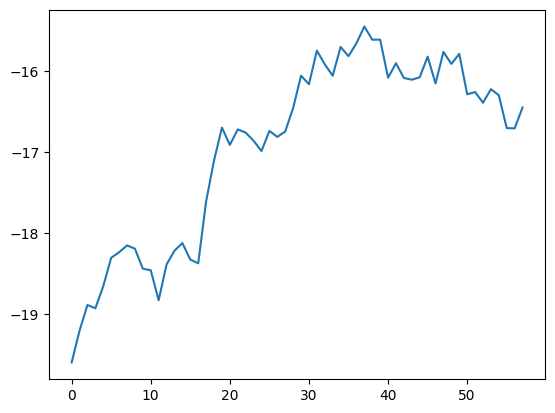

In [75]:
plt.plot(val_loss_list)

In [76]:
torch.save(model.state_dict(), "../model.pth")

In [77]:
model_load = WaveUNet().to(device)
model_load.load_state_dict(torch.load("../model.pth"))

<All keys matched successfully>

In [78]:
test(test_dataloader, model_load, test_loss_fn)

Test loss : -15.001210871851072



In [40]:
def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(x.tobytes(), frame_rate=sr, sample_width=2, channels=1)
    song.export(f, format="mp3", bitrate="320k")

# write('/content/gdrive/MyDrive/test.mp3', 22050, np.array(splittest[0][0].cpu()), normalized=True)

In [92]:
def sdr_loss_mean_removezero(y_target, y_pred, loss_fn):
    assert y_target.shape == y_pred.shape
    loss = 0
    y_target_reshape = y_target.reshape(-1, y_target.shape[-1])
    y_pred_reshape = y_pred.reshape(-1, y_pred.shape[-1])
    y_size = y_target_reshape.shape[0]
    for y_stem, pred_stem in zip(y_target_reshape, y_pred_reshape):
        if y_stem.count_nonzero().item() != 0:
            loss += loss_fn(pred_stem, y_stem).item()
    return loss/y_size

In [93]:
def test_removezero(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += sdr_loss_mean_removezero(y, pred, loss_fn)
    test_loss /= len(dataloader)
    print(f"Test loss : {test_loss}\n")
    

In [94]:
test_removezero(test_dataloader, model_load, test_loss_fn)

Test loss : -1.4399132912512869



In [106]:
song_index = 4

test_arr = torch.Tensor(test_ds[song_index][0]).to(device)
test_arr = torch.unsqueeze(test_arr, 0)

model_load.eval()
with torch.no_grad():
    pred = model_load(test_arr)

pred = pred.cpu()

In [111]:
print(test_loss_fn(pred[0][0], torch.Tensor(test_ds[song_index][1][0])),
test_loss_fn(pred[0][1], torch.Tensor(test_ds[song_index][1][1])),
test_loss_fn(pred[0][2], torch.Tensor(test_ds[song_index][1][2])))

tensor(7.6910, device='cuda:0') tensor(-3.0192, device='cuda:0') tensor(4.2979, device='cuda:0')


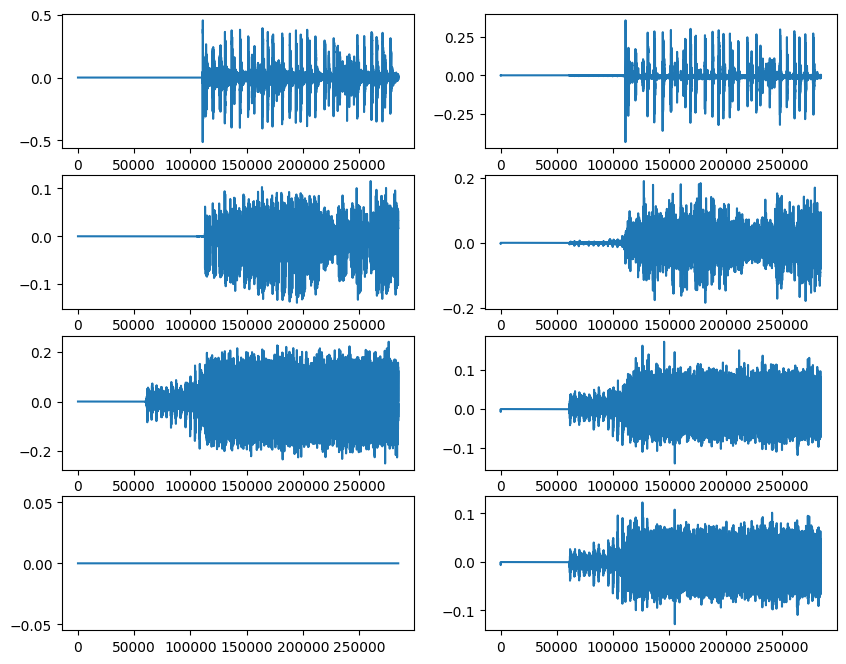

In [107]:
stem_index = 0

plt.figure(figsize=(10, 8))

for i in range(4):
    plt.subplot(4, 2, i*2+1)
    plt.plot(test_ds[song_index][1][i])
    plt.subplot(4, 2, i*2+2)
    plt.plot(pred[0][i])
plt.show()

for i in range(4):
    soundfile.write(f'./output/test_orign_{i}.wav', test_ds[song_index][1][i], 22050, format='wav')
    soundfile.write(f'./output/test_out_{i}.wav', pred[0][i], 22050, format='wav')